In [29]:
import cv2
import os
from glob import glob
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms as tt
import torchmetrics.functional as metrics

(224, 224)


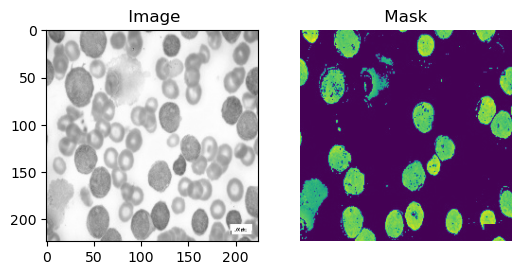

In [30]:
root="/kaggle/input/leukemia"
def imgshow(title=None, size=5):    
            folder_list=os.listdir("./kaggle/Original")
            title=folder_list[random.randint(0,len(folder_list))]
            cell_path="./kaggle/Original/"+title
            data_list=os.listdir(cell_path)
            cell_path=os.path.join(cell_path, data_list[random.randint(0,len(data_list))])

            img=cv2.imread(cell_path)
            mask=cv2.imread(cell_path.replace("Original", "Segmented"))

            plt.figure(figsize=(size+(img.shape[0]/img.shape[1]),size))

            plt.subplot(1,2,1)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(" Image")

            plt.subplot(1,2,2)
            mask=cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            plt.imshow(mask)
            print(mask.shape)
            plt.title(" Mask ")
            plt.axis("off")
            plt.show()
    
img=cv2.imread("./kaggle/Original/Benign/WBC-Benign-001.jpg")
mask=cv2.imread("./kaggle/Segmented/Benign/WBC-Benign-001.jpg")

imgshow()

In [31]:
DATA_DIR = "./kaggle"
BATCH_SIZE = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE=64
EPOCHS=30

if device == 'cuda':
    ngpu = torch.cuda.device_count()
else:
    ngpu = 0

transform = tt.Compose([
    tt.ToTensor(),
    tt.Resize(size=IMG_SIZE, antialias=True),
    tt.CenterCrop(IMG_SIZE),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [32]:
class CellData(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_dir = os.path.join(data_dir, "Original")
        self.mask_dir = os.path.join(data_dir, "Segmented")
        self.image_list = []

        for inst in os.listdir((os.path.join(data_dir, "Original"))):
            name_list = os.listdir(os.path.join(data_dir, "Original", inst))
            for name_ in name_list:
                self.image_list.append(inst + "/" + name_)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)  # Read the mask in grayscale

        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask
    
dataset = CellData(DATA_DIR, transform=transform)
n=len(dataset)
val_percent=0.1
n_val = int(n * val_percent)
n_train = n - n_val

train_data, val_data = torch.utils.data.random_split( dataset,[n_train, n_val])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          num_workers=ngpu)

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=False,
                        drop_last=False,
                        num_workers=ngpu)

In [33]:
'''CONV BLOCK'''
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
            
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x

'''ENCODER BLOCK'''
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
        
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

'''DECODER BLOCK'''
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
        
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

'''UNET MODEL'''
class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        
        self.b = conv_block(512, 1024)
         
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
         
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
    def forward(self, inputs):
        
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        
        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)
        return torch.sigmoid(outputs)
    
'''DICE LOSS'''
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
        
    def forward(self,pred, target):
        smooth = 1.
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )
    
'''MODEL INSTANCE'''
model = UNET().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)
criterion = diceloss()
if (device == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))

In [34]:
train_losses, val_losses = [], []

for epoch in tqdm(range(EPOCHS)):
    
    '''Training the Model'''
    train_loss = 0
    train_correct, train_total = 0,0
    for idx, (data, mask) in enumerate(train_loader):
        data, mask = data.to(device), mask.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        mask=tt.functional.rgb_to_grayscale(mask)
        loss = criterion(output, mask)
        train_loss=loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    '''Validadting the Model'''
    val_loss = 0
    with torch.no_grad():
        for idx, (data, mask) in enumerate(val_loader):
            data, mask = data.to(device), mask.to(device)
            
            output = model(data)
            mask=tt.functional.rgb_to_grayscale(mask)
            loss = criterion(output, mask)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print('Epoch[%d/%d] - Training_loss: %.4f Validation_loss: %.4f' % (epoch, EPOCHS, train_loss, val_loss))

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch[0/30] - Training_loss: 0.0027 Validation_loss: 1.0021
Epoch[1/30] - Training_loss: 0.0027 Validation_loss: 0.9990
Epoch[2/30] - Training_loss: 0.0027 Validation_loss: 0.9959
Epoch[3/30] - Training_loss: 0.0027 Validation_loss: 0.9932
Epoch[4/30] - Training_loss: 0.0027 Validation_loss: 0.9915
Epoch[5/30] - Training_loss: 0.0027 Validation_loss: 0.9903
Epoch[6/30] - Training_loss: 0.0027 Validation_loss: 0.9895
Epoch[7/30] - Training_loss: 0.0027 Validation_loss: 0.9889
Epoch[8/30] - Training_loss: 0.0027 Validation_loss: 0.9885
Epoch[9/30] - Training_loss: 0.0027 Validation_loss: 0.9881
Epoch[10/30] - Training_loss: 0.0027 Validation_loss: 0.9878
Epoch[11/30] - Training_loss: 0.0027 Validation_loss: 0.9876
Epoch[12/30] - Training_loss: 0.0027 Validation_loss: 0.9873
Epoch[13/30] - Training_loss: 0.0027 Validation_loss: 0.9871
Epoch[14/30] - Training_loss: 0.0027 Validation_loss: 0.9869
Epoch[15/30] - Training_loss: 0.0027 Validation_loss: 0.9867
Epoch[16/30] - Training_loss: 0.00

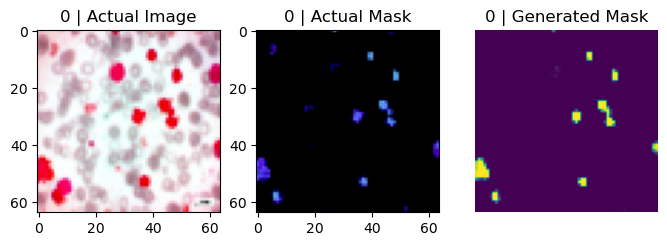

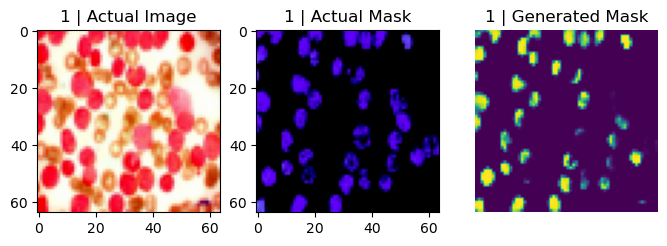

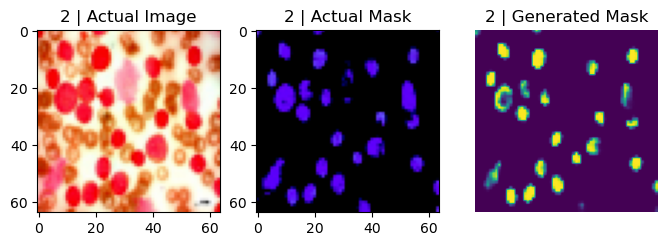

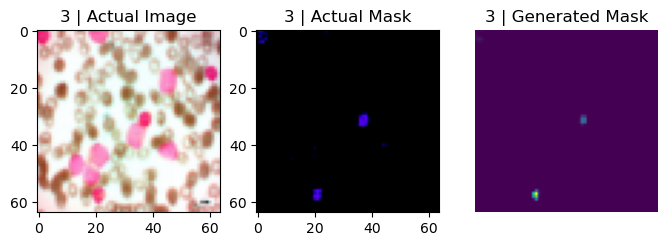

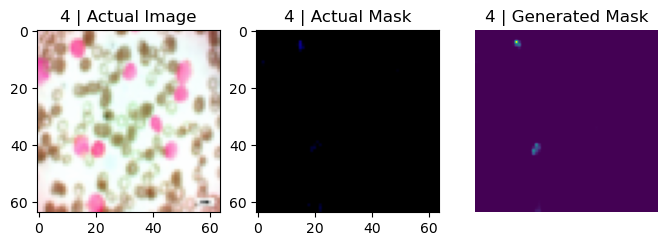

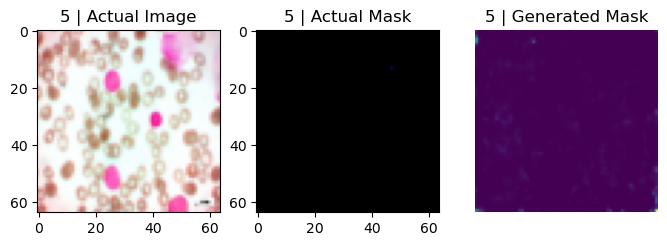

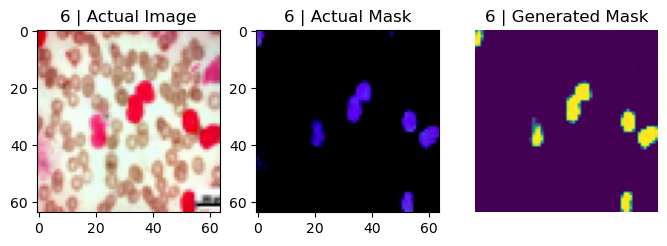

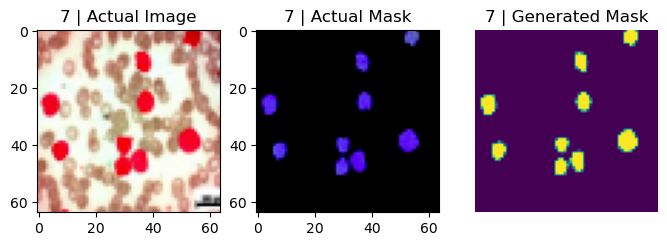

In [39]:
def visualise(images, mask ,generated_mask, size=7):
    data_instances = len(generated_mask)

    for i in range(data_instances):
        generated_mask_i = np.transpose(generated_mask[i].cpu().detach().numpy(),(1, 2, 0))
        mask_i = np.transpose(mask[i].cpu().detach().numpy(),(1, 2, 0))
        image_i = np.transpose(images[i].cpu().detach().numpy(),(1, 2, 0))
        
        plt.figure(figsize=(size+(image_i.shape[0]/image_i.shape[1]),size))

        plt.subplot(1,3,1)
        plt.imshow(image_i)
        plt.title(str(i)+" | Actual Image")

        plt.subplot(1,3,2)
        plt.imshow(mask_i)
        plt.title(str(i)+" | Actual Mask")
        
        plt.subplot(1,3,3)
        plt.imshow(generated_mask_i)
        plt.title(str(i)+" | Generated Mask")
        
        plt.axis("off")
        plt.show()

for data, mask in train_loader:
    outputs=model(data)
    visualise(data, mask, outputs)
    break

In [40]:
torch.save(model.state_dict(), "leukemia_cells_unet.pt")

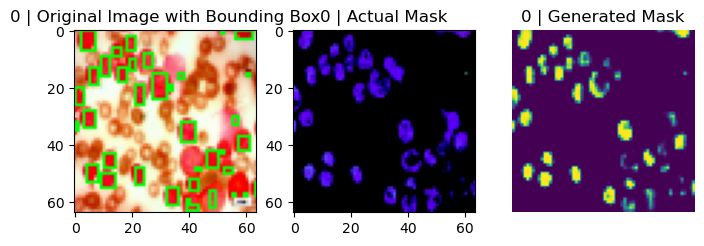

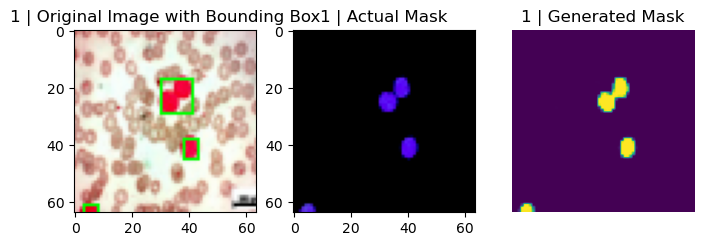

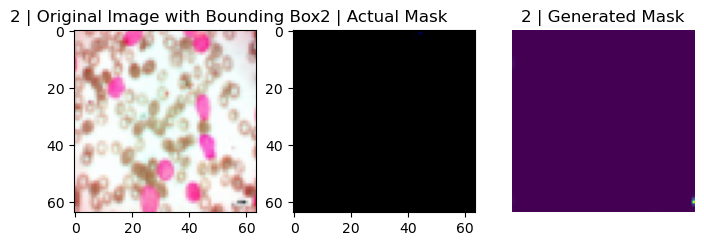

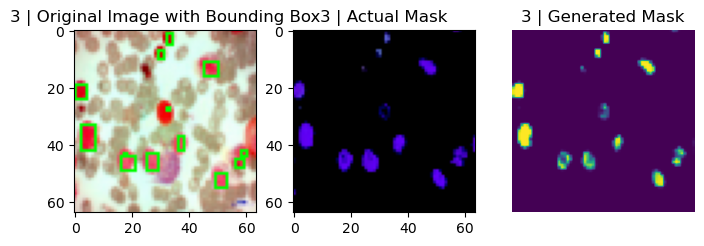

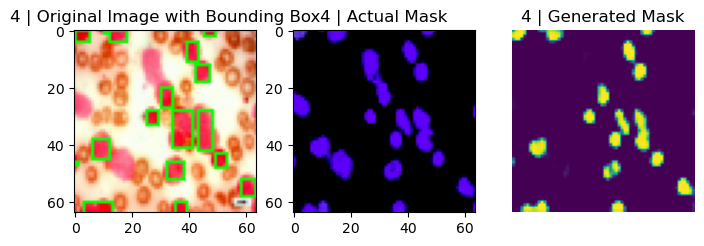

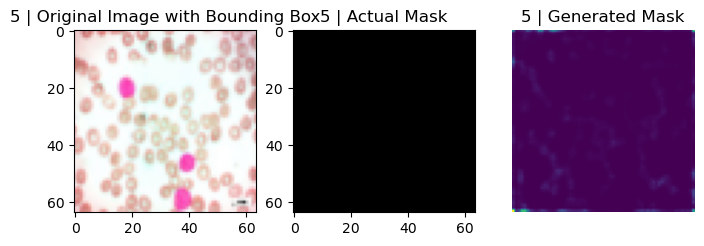

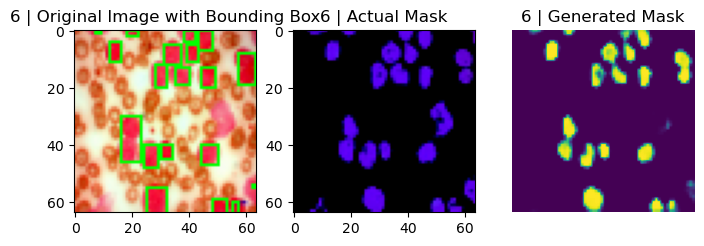

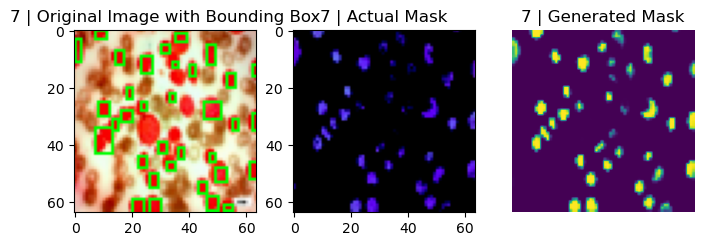

In [42]:
import cv2

# Function to draw bounding box
def draw_bbox(image, mask):
    # Convert mask to binary
    _, binary_mask = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding box on original image
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)

    return image

# Visualize images with bounding boxes
def visualise_with_bbox(images, mask, generated_mask, size=7):
    data_instances = len(generated_mask)

    for i in range(data_instances):
        generated_mask_i = np.transpose(generated_mask[i].cpu().detach().numpy(),(1, 2, 0))
        mask_i = np.transpose(mask[i].cpu().detach().numpy(),(1, 2, 0))
        image_i = np.transpose(images[i].cpu().detach().numpy(),(1, 2, 0))

        # Draw bounding box
        image_with_bbox = draw_bbox(image_i.copy(), generated_mask_i)

        plt.figure(figsize=(size+(image_i.shape[0]/image_i.shape[1]),size))

        plt.subplot(1, 3, 1)
        plt.imshow(image_with_bbox)
        plt.title(str(i) + " | Original Image with Bounding Box")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_i)
        plt.title(str(i) + " | Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(generated_mask_i)
        plt.title(str(i) + " | Generated Mask")

        plt.axis("off")
        plt.show()

# Visualize images with bounding boxes
for data, mask in train_loader:
    outputs = model(data)
    visualise_with_bbox(data, mask, outputs)
    break
